# **EiA 2030 - TRANSFORM Seminar Series**
## Solutions to streamline data and tools for climate-smart and sustainable agronomy intensification
#### **Siyabusa Mkhulani and Eduardo Garcia Bendito** | 21/04/2021

-----
![](img/green_geom.png)

<span style="font-size:1.25em;">This session will cover some practical examples to develop and integrate data and tools required to develop climate-smart and sustainable agronomy solutions at scale. Following the general framework proposed in [TRANSFORM](https://teams.microsoft.com/l/entity/com.microsoft.teamspace.tab.wiki/tab::2eef53a9-c9c3-4edc-b4dc-0c7dbb2feb05?context=%7B%22subEntityId%22%3A%22%7B%5C%22pageId%5C%22%3A6%2C%5C%22origin%5C%22%3A2%7D%22%2C%22channelId%22%3A%2219%3A66add638f81245ae88248385ec8ed3ab%40thread.tacv2%22%7D&tenantId=6afa0e00-fa14-40b7-8a2e-22a7f8c357d5) (see below) following the ideas to achieve a collaborative and efficient outcome in an asynchronous way, contributing materials, functionality, data and ideas.</span>

![](img/TRANSFORM_framework.png)

<span style="font-size:1.25em;">The session tries to give a general overview of the TRANSFORM Turnkey Solutions, presenting a few examples of funtionalities. Also, it aims to present a working example of how to organize, work, and contribute materials in a collaborative and asynchronous way. To do so, it shows some pracical examples of code and idenified relevant data. Here, we present an example to source data from:</span>

* <span style="font-size:1.25em;">[NASA POWER](https://power.larc.nasa.gov/docs/services/api/)</span>
* <span style="font-size:1.25em;">[Google Earth Catalog](https://developers.google.com/earth-engine/datasets/catalog?hl=en)</span>
* <span style="font-size:1.25em;">[OpenLandMap.org](https://openlandmap.org/)</span>

<span style="font-size:1.25em;">You can find this notebook at: [https://github.com/EiA2030/source_data/source_data_TRANSFORM_seminar_20210421.ipynb](https://github.com/EiA2030/source_data)</span>

## NASA POWER API

<span style="font-size:1.25em;">NASA POWER Provides solar and meteorological data sets from NASA research for support of renewable energy, building energy efficiency and supporting agricultural data needs. Data services are provided through a series of restful Application Programming Interfaces (API) distributing Analysis Ready Data to end users.</span>

<span style="font-size:1.25em;">In this first example, we use the [``nasapower`` R package](https://github.com/ropensci/nasapower)</span>

![](img/logo.png)


<span style="font-size:1.25em;">1. Download NASA's POWER data using CG Labs Weather Data Tool</span>

![](img/video1.gif)

<span style="font-size:1.25em;">2. Format your selected NASA POWER data to the desired format (table; vector points; raster stack)</span>

<span style="font-size:1.25em;">[``nasapower_json2output.R``]() is a R script with 3 functions which reads your JSON file from NASA POWER and formats it into different outputs. Let's look at it:</span>

<span style="font-size:1.25em;">First, read the JSON and unnest the relevant properties. We look for **geometry** (contains the coordinates) and **parameter** (contains the selected variable). The parameter should be ``t2m``, ``ws10m`` or ``ps``. Then, we create a ``data.frame`` of the following format:</span> 

| <span style="font-size:1.25em;">lat</span>              | <span style="font-size:1.25em;">long  </span>            | <span style="font-size:1.25em;">date</span>           | <span style="font-size:1.25em;">parameter (t2m; ps, ws10m)</span>|
| ---------------- |:-----------------:|:--------------:|--------------------------:|
| <span style="font-size:1.25em;">datatype: numeric</span>| <span style="font-size:1.25em;">datatype: numeric</span> | <span style="font-size:1.25em;">datatype: date | datatype: numeric</span>         |


<span style="font-size:1.25em;">For example:</span>

In [43]:
f_tblR.JSON <- function(file_name,p){
          require(rjson)
          require(tidyverse)
          require(sf)
          json <- enframe(unlist(fromJSON(file = file_name)))
          json <- json %>% 
            separate(name, into = c(paste0("name", 1:5)), fill = "right") %>%
            filter(name1 == "features" &
                     name2 == "geometry" &
                     name3 %in% c("coordinates1", "coordinates2") |
                     (name1 == "features" &
                        name2 == "properties" &
                        name3 == "parameter")) %>%
            dplyr::select(name5, value)
          
          json <- json %>%
            mutate(lat = if_else(is.na(name5), as.numeric(value), as.numeric(NA))) %>%
            mutate(lon = if_else(is.na(name5), as.numeric(lag(value, n = 1L)), as.numeric(NA))) %>%
            mutate(date = if_else(is.na(name5), as.Date(NA), as.Date(name5, "%Y%m%d"))) %>% 
            mutate(parameter = if_else(is.na(name5), as.numeric(NA), as.numeric(value))) %>%
            dplyr::select(lat, lon, date, parameter) %>%
            filter(!is.na(lat) & !is.na(lon) |
                     (!is.na(date) & !is.na(p)))
          colnames(json) <- c("lat", "lon", "date",p)
          
          while(length(ind <- which(is.na(json$lat))) > 0){
            json$lat[ind] <- json$lat[ind -1]
          }
          while(length(ind <- which(is.na(json$lon))) > 0){
            json$lon[ind] <- json$lon[ind -1]
          }
          
          json <- json %>%
            filter(!is.na(date) & !is.na(p))
          json <- json %>%
            arrange(date, lat, lon)
          return(json)
        }
head(f_tblR.JSON("/home/jovyan/work/git/source_data/data/POWER_Regional_Daily_20210101_20210110_d2b00515.json", "t2m"))

lat,lon,date,t2m
<dbl>,<dbl>,<date>,<dbl>
-1.75,36.25,2021-01-01,22.10
-1.75,36.75,2021-01-01,20.16
-1.75,37.25,2021-01-01,20.26
-1.75,37.75,2021-01-01,21.72
-1.75,38.25,2021-01-01,24.00
-1.75,38.75,2021-01-01,26.74


<span style="font-size:1.25em;">Alternatively, if we want to create table of geometries:</span> 

In [46]:
f_point.data <- function(file_name, p){
  require(sf)
  data <- f_tblR.JSON(file_name, p)
  data <- st_as_sf(data, coords = c("lon", "lat"), crs = 4326)
#   data <- data %>%
#     spread(date, p)
  colnames(data) <- c('YYYYMMDD', p, "geometry")#gsub('-', '_', colnames(data), fixed=TRUE)
  return(data)
}
f_point.data("/home/jovyan/work/git/source_data/data/POWER_Regional_Daily_20210101_20210110_d2b00515.json", "t2m")

,YYYYMMDD,t2m,geometry
,<date>,<dbl>,<POINT [°]>
1,2021-01-01,22.10,POINT (36.25 -1.75)
2,2021-01-01,20.16,POINT (36.75 -1.75)
3,2021-01-01,20.26,POINT (37.25 -1.75)
4,2021-01-01,21.72,POINT (37.75 -1.75)
5,2021-01-01,24.00,POINT (38.25 -1.75)
6,2021-01-01,26.74,POINT (38.75 -1.75)
7,2021-01-01,28.03,POINT (39.25 -1.75)
8,2021-01-01,18.28,POINT (36.25 -1.25)
9,2021-01-01,18.67,POINT (36.75 -1.25)


<span style="font-size:1.25em;">Finally, we can also create a spatio-temporal raster stack. Here we can also define the final resolution:</span>

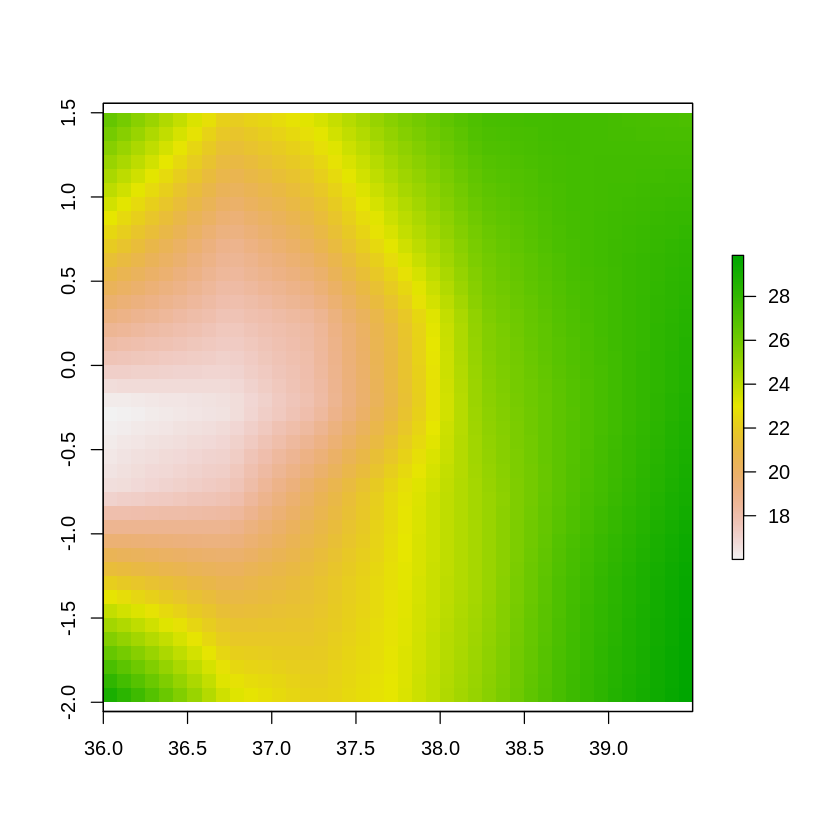

In [45]:
f_data.Cube <- function(file_name, p, tr){
  tbl <- f_tblR.JSON(file_name, p)
  pnt <- f_point.data(file_name, p)
  require(raster)
# Create new objects for each parameter selected  
  lapply(names(pnt)[!grepl(paste(c("YYYYMMDD","geometry"), collapse="|"), names(pnt))], function(x) assign(x, pnt[c("YYYYMMDD",x)], envir = .GlobalEnv))
# Rasterize the sf of each parameter at a selected resolution (tr)
  for(i in names(pnt)[!grepl(paste(c("YYYYMMDD", "geometry"), collapse="|"), names(pnt))]){
    r <- raster(ext = extent(st_bbox(pnt)) + 0.5, crs = "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0", resolution = 0.5)
    st <- stack()
    j <- get(i, envir = .GlobalEnv)
    j <-tidyr::spread(j, "YYYYMMDD", i)
    ## Re-format column labels
    colnames(j) <- gsub('-', '_', colnames(j), fixed=TRUE)
    n <- 1
    for(k in names(j)[!grepl("['geometry]", names(j))]){
      vals <- dplyr::pull(j, k) # Read vector with`` the values of the date (k)
      r <- raster(ext = extent(st_bbox(j)) + 0.5, crs = "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0",
                  resolution = tr) # Create Raster object with the desired Target Resolution
      # # Add this part to work inside of CG Labs
      # # It works with library(raster) object SpatialPointsDataFrame
      lonlat <- cbind(tbl$lon, tbl$lat)
      df <- data.frame(ID=1:nrow(lonlat), i = vals)
      colnames(df) <- c("ID", i)
      v <- SpatialPointsDataFrame(lonlat, data=df, proj4string = CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"))
      ras <- rasterize(x = v,
                       y = raster(ext = extent(st_bbox(j)) + 0.5, crs = "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0", resolution = 0.5),
                       field = i)
      # # # This part is removed (not working inside CG Labs)
      # ras <- rasterize(x = j,
      #                  y = raster(ext = extent(st_bbox(j)) + 0.5, resolution = 0.5),
      #                  field = vals)
      crs(ras) <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"
      ras <- resample(ras, r, method = "bilinear")
      st <- stack(st,ras)
      names(st[[n]]) <- as.character(paste0('date_', gsub("_", "-", k))) # https://stackoverflow.com/questions/36844460/why-does-r-add-an-x-when-renaming-raster-stack-layers
      # Create RasterStack of each object
      assign(paste0(i), st , envir = .GlobalEnv)
      remove(vals,ras)
      n <- n + 1
    }
  }
}

raster_data <- f_data.Cube("/home/jovyan/work/git/source_data/data/POWER_Regional_Daily_20210101_20210110_d2b00515.json", "t2m", 0.0833)
plot(t2m[[8]])

<span style="font-size:1.25em;">Alternatively, we can also use the NASA POWER API directly, including more parameters in a single query using ``nasaP``:</span>

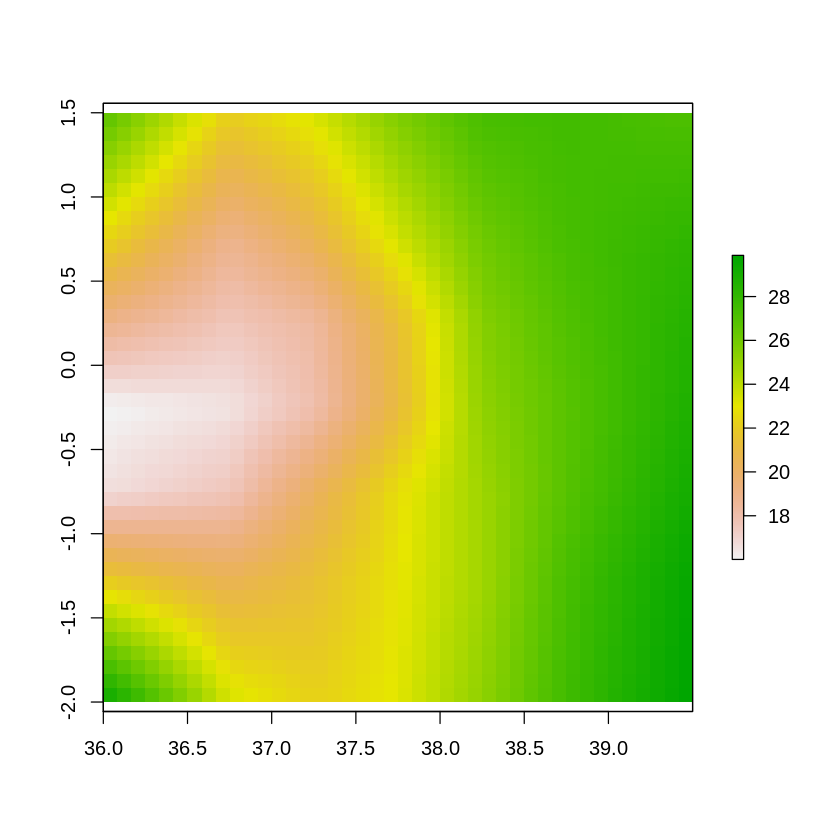

In [50]:
source('/home/jovyan/work/git/source_data/R/nasapower_download.R')
nasaP(tr = 0.08333, xmin = 36, ymin = -2, xmax = 39, ymax = 1, sdate = "2021-01-01", edate = "2021-01-10", "T2M", "T10M", "PS", "RH2M")
plot(T2M[[8]])

## Google Earth Catalogue

![](img/logo_gee1.png)

<span style="font-size:1.25em;">Earth Engine's public data catalog includes a variety of standard Earth science raster datasets. You can import these datasets into your script environment and start analyzing data using Google's computing resources. Results can then be exported and saed on premises.</span>

<span style="font-size:1.25em;">Using the [``rgee`` R package](https://r-spatial.github.io/rgee/index.html) we can interact with Google Earth Engine APIs and get access to a large variety of spatio-temporal datasets including: CHIRPS, Landsat, and many others.</span>

<span style="font-size:1.25em;">Using ``daily_data_gee.R`` and ``extract_daily_data.R`` we can export results as a ``FeatureCollection`` in JSON format.</span>


## OpenLandMap.org

<span style="font-size:1.25em;">